# Deconvolution

Images acquired on a microscope are blurred as the result of the diffraction of the light collected by the objective. The blur can be modelled as convolution of the image by the point spread function (PSF). The optical transfer function is defined as the Fourier transform of the PSF and the convolution theorem indicates that the Fourier transform (FT) of the recorded image is the product of the optical transfer function and the FT of the sample. The optical transfer function is zero beyond the diffraction limit defined in the xy plane as half the ratio of the wavelength and the numerical aperture of the objective. This result as unobservable frequencies in the acquired image.

Recovering the fluorophore density of the sample from an acquired image amount at inversing the convolution process and is called deconvolution. As convolution is the product of the OTF by the FT of the sample, deconvolution should be the division of the FT of the image by the OTF. However, the OTF being zero outside the resolution limit, the division is ill posed and simply amplify the noise of the acquired image.

Various strategies can be used then to recover the fine structure of the sample whilst mitigating the noise amplification. 

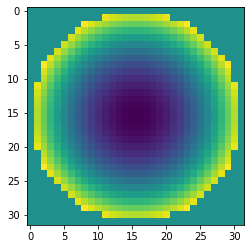

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def zernike_polynomial(r,t,coefficients):
    '''
    Zernike polynomials
    Parameters
    ----------
    r : radius
    t : angle
    coefficients: coefficients (up to 15)
    Result
    ------
    P : polynomial evaluated on rho, theta
    '''
    if coefficients is None:
        return np.zeros(r,shape)
    if coefficients.shape[0] < 15:
        coefficients = np.pad(coefficients,(0,15-coefficients.shape[0]))
    r2 = np.square(r)
    r3 = np.power(r,3.0)
    r4 = np.power(r,4.0)
    c = np.cos(t)
    s = np.sin(t)
    c2 = np.cos(2*t)
    s2 = np.sin(2*t)
    c3 = np.cos(3*t)
    s3 = np.sin(3*t)
    P = np.zeros(r.shape)
    P = P + coefficients[0] * r * c
    P = P + coefficients[1] * r * s
    P = P + coefficients[2] * (2. * r2 - 1.)
    P = P + coefficients[3] * r2 * c2
    P = P + coefficients[4] * r2 * s2
    P = P + coefficients[5] * (3.*r2-2.) * r * c
    P = P + coefficients[6] * (3.*r2-2.) * r * s
    P = P + coefficients[7] * (6.*r4 - 6.*r2 + 1.)
    P = P + coefficients[8] * r3 * c3
    P = P + coefficients[9] * r3 * s3
    P = P + coefficients[10] * (4.*r3 - 3) * r2 * c2
    P = P + coefficients[11] * (4.*r3 - 3) * r2 * s2
    P = P + coefficients[12] * (10 * r4 - 12 * r2 + 3) * r  * c
    P = P + coefficients[13] * (10 * r4 - 12 * r2 + 3) * r  * s
    P = P + coefficients[13] * ((20 * r4 - 30 * r2 + 12)  * r2 - 1)
    P = np.where(r<1.0,P,0)
    return P

x,y = np.meshgrid(np.linspace(-1,1,32),np.linspace(-1,1,32))
rho = np.sqrt(np.square(x)+np.square(y))
theta = np.arctan2(y,x)
coefficients = np.array([0,0,1,0,0,0,0])
P = zernike_polynomial(rho,theta,coefficients)
plt.imshow(P)


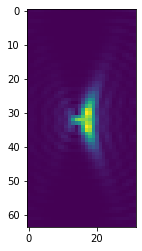

In [45]:
import numpy as np
import math
import matplotlib.pyplot as plt
import time

def generate_otf3d_grid(shape, pixel_size):
    """
    Generate a grid on which to evaluate the optical transfer function
    Parameters
    ----------
    shape : list [nx,ny,nz] giving the shape of the final array
    pixel_size : sampling in [x,y,z]    
    Returns
    -------
    kx,ky,kz,z: frequency grid in x and y and spatial space in z
    """
    f = [np.fft.fftfreq(n, pixel_size[k]) for k, n in enumerate(shape)]
    ez = np.concatenate((np.arange(0,shape[2]//2), np.arange((-shape[2])//2,0))) * pixel_size[2]
    [kx,ky,kz] = np.meshgrid(*f)
    z = np.meshgrid(f[0],f[1],ez)[2]
    return kx,ky,kz,z


def generate_otf3d_on_grid(grid,NA,wavelength,medium_refractive_index,aberrations=None):
    """
    Generate a diffraction limited wide field optical transfer function and point spread function
    Parameters
    ----------
    grid : tuple [kx,ky,z] with grid on which to evaluate the otf
    pixel_size : sampling in [x,y,z]
    NA : numerical aperture
    wavelength : wavelength of the emitted light
    medium_refractive_index : refractive index of the immersion medium
    Returns
    --------
    otf : the optical transfer function as an array of shape 'shape'
    psf : the point spread function as an array of shape 'shape' centerd in 0,0,0
    """
    d2 = np.square(grid[0]) + np.square(grid[1])
    rho = np.sqrt(d2) * wavelength / NA
    theta = np.arctan2(grid[1],grid[0])
    P = np.where(rho <= 1.0, 1.0, 0.0)
    defocus = grid[3] * np.sqrt(np.clip((medium_refractive_index / wavelength)**2 - d2,0,None))
    phi = zernike_polynomial(rho,theta,aberrations)
    psf = np.square(np.abs(np.fft.fft2(P * np.exp(2j * math.pi * (defocus+phi)),axes=[0,1])))
    psf = psf / psf.sum()
    otf = np.fft.fftn(psf)
    return otf, psf

def generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index,aberrations=None):
    """
    Generate a diffraction limited wide field optical transfer function and point spread function
    Parameters
    ----------
    shape : list [nx,ny,nz] giving the shape of the final array
    pixel_size : sampling in [x,y,z]
    NA : numerical aperture
    wavelength : wavelength of the emitted light
    medium_refractive_index : refractive index of the immersion medium
    Returns
    --------
    otf : the optical transfer function as an array of shape 'shape'
    psf : the point spread function as an array of shape 'shape' centerd in 0,0,0
    """
    grid = generate_otf3d_grid(shape, pixel_size)
    return generate_otf3d_on_grid(grid,NA,wavelength,medium_refractive_index,aberrations)

def generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index,aberrations=None):
    f = [np.fft.fftfreq(n, pixel_size[k]) for k, n in enumerate(shape)]
    ez = np.concatenate((np.arange(0,shape[2]//2), np.arange((-shape[2])//2,0))) * pixel_size[2]
    [kx,ky,kz] = np.meshgrid(*f)
    z = np.meshgrid(f[0],f[1],ez)[2]
    d2 = np.square(kx) + np.square(ky)
    rho = np.sqrt(d2) * wavelength / NA
    theta = np.arctan2(ky, kx)
    P = np.where(rho <= 1.0, 1.0, 0.0)
    defocus = z * np.sqrt(np.clip((medium_refractive_index / wavelength)**2 - d2,0,None))
    phase = defocus + zernike_polynomial(rho,theta,aberrations)
    psf = np.square(np.abs(np.fft.fft2(P * np.exp(2j * math.pi * phase),axes=[0,1]))
    psf = psf / psf.sum()
    otf = np.fft.fftn(psf)
    return otf, psf



shape = [64,64,32] 
pixel_size = [100,100,300] 
wavelength = 500
NA = 1
medium_refractive_index = 1.3
aberrations = np.array([0,0,0,0.5])
start = time.time()
otf,psf = generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index,aberrations)
print(f'Elsapsed time {time.time()-start}')

start = time.time()
otf,psf = generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index,aberrations)

plt.imshow(np.fft.fftshift(psf[:,0,:]))

Text(0.5, 1.0, 'Simulated sample')

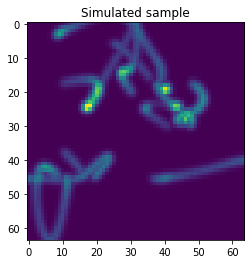

In [58]:
import scipy.ndimage

def generate_test_image(shape,N=10,L=100,smooth=10):
    """
    Generate a test image with fibers

    Parameters
    ----------
    shape : list of int giving the shape of the generated image
    N : number of fibers
    L : number of points in each fiber
    smooth : smoothness of the fibers
    
    Output
    ------
    img : numpy array of given shape normalized between 0 and 1
    """
    D = len(shape)
    # generate points on smooth curves as a N x L x D array
    P = np.tile(np.repeat(np.reshape(np.array(shape), [1,1,D]), N, axis=0) * (.1 + .8 * np.random.rand(N,1,D)), [1,L,1])
    P = P + np.cumsum(scipy.ndimage.gaussian_filter1d(2*np.random.randn(N,L,D), smooth, axis=1),axis=1)
    space = tuple([np.arange(k) for k in shape])
    X = np.meshgrid(*space)
    img = np.zeros(shape)
    for p in np.reshape(P,(N*L,D)):
        img = img + np.exp(-0.5*np.sum(np.stack([np.square(p[k]-X[k]) for k in range(D)]), axis=0))
    img = img / img.max()
    return img

img = generate_test_image(shape,10,100)
plt.imshow(np.amax(img,axis=2))
plt.title('Simulated sample')

To simulate an image acquired by a microscope, we multiply in Fourier space the sample by the optical transfer function. We also add some Poisson noise to emulate the photon limited nature of the acquisition process.

Text(0.5, 1.0, 'Simulated data')

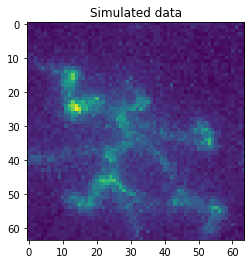

In [3]:
data = 1000 * np.real(np.fft.ifftn(np.fft.fftn(img) * otf))
data = np.random.poisson(data)
plt.imshow(np.amax(data, 2))
plt.title('Simulated data')

We have simulated a realistic image. We will now try to recover the original sample using a deconvolution algorithm. We implement here the Richardson-Lucy deconvolution.

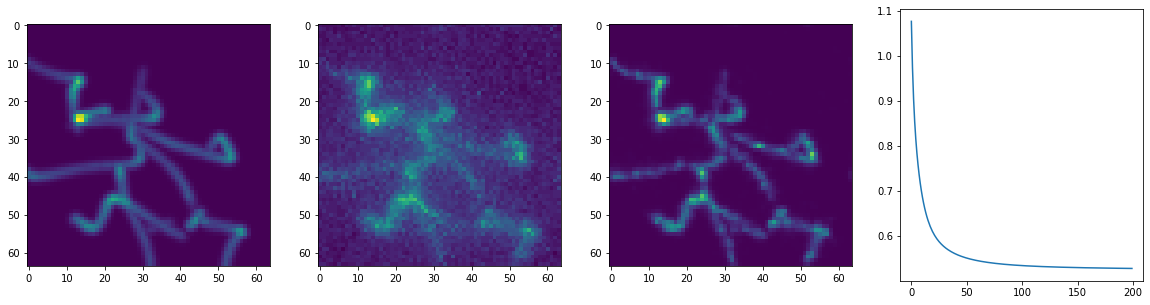

In [4]:
def kulback_leibler_divergence(data,estimate,otf,background):
    """
    Compute the kullback Leibler divergence
    Parameters
    ----------
    data       : numpy array 
    estimate   : estimate
    otf        : numpy array of the same size than data
    background : background level
    Result
    ------
    The kullback Leibler divergence
    """
    blurred = np.real(np.fft.ifftn(otf * np.fft.fftn(estimate+background)))
    return np.mean(blurred - data + data * np.log(np.clip(data/blurred,a_min=1e-6,a_max=None))) 

def deconvolve_richardson_lucy(data, otf, background=0, iterations=100):
    """ 
    Deconvolve data according to the given otf using a Richardson-Lucy algorithm
    Parameters
    ----------
    data       : numpy array
    otf        : numpy array of the same size than data
    background : background level
    iterations : number of iterations
    Result
    ------
    estimate   : estimated image
    dkl        : Kullback Leibler divergence
    """
    estimate = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(data-background))), a_min=1e-6, a_max=None)
    dkl = np.zeros(iterations)
    for k in range(iterations):
        blurred = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(estimate+background))), a_min=1e-6, a_max=None)
        ratio = data / blurred
        estimate = estimate * np.real(np.fft.ifftn(otf * np.fft.fftn(ratio)))
        dkl[k] = np.mean(blurred - data + data * np.log(np.clip(ratio,a_min=1e-6,a_max=None)))
    return estimate, dkl

deconvolved1, dkl1 = deconvolve_richardson_lucy(data,otf,0,200)
fig, ax = plt.subplots(1,4,figsize=[20,5])
ax[0].imshow(np.amax(img, 2))
ax[1].imshow(np.amax(data, 2))
ax[2].imshow(np.amax(deconvolved1, 2))
ax[3].plot(dkl1)
ax[3].set_title('Kullback leibler divergence')

Let's now implement an accelerate version of the Richardson Lucy using the principle of heavy ball acceleration.

MSE11 793.1037749216388 MSE2 2466.6102844022034


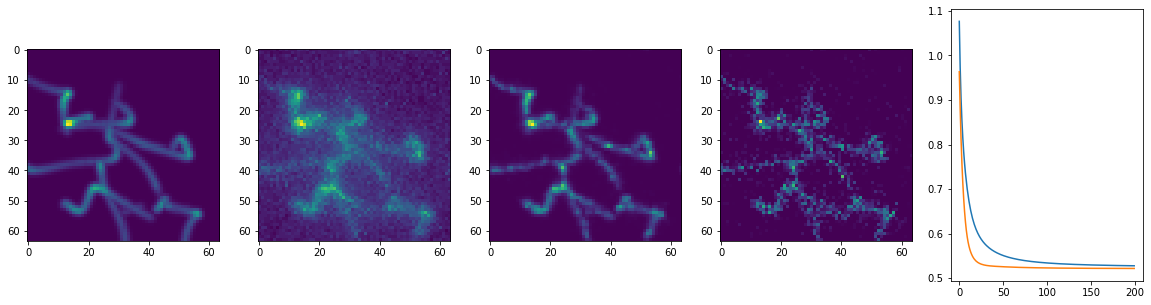

In [5]:
def deconvolve_richardson_lucy_heavy_ball(data, otf, background, iterations):
    """ 
    Deconvolve data according to the given otf using a scaled heavy ball Richardson-Lucy algorithm
    Parameters
    ----------
    data       : numpy array
    otf        : numpy array of the same size than data
    iterations : number of iterations
    Result
    ------
    estimate   : estimated image
    dkl        : the kullback leibler divergence (should tend to 1/2)
    Note
    ----
    https://doi.org/10.1109/tip.2013.2291324
    """
    old_estimate = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(data - background))), a_min=0, a_max=None)
    estimate = data
    dkl = np.zeros(iterations)
    for k in range(iterations):
        beta = (k-1.0) / (k+2.0)
        prediction = estimate + beta * (estimate -  old_estimate)
        blurred = np.clip(np.real(np.fft.ifftn(otf * np.fft.fftn(prediction + background))), a_min=1e-6, a_max=None)
        ratio = data / blurred
        gradient = 1.0 - np.real(np.fft.ifftn(otf * np.fft.fftn(ratio)))
        old_estimate = estimate
        estimate = np.clip(prediction - estimate * gradient, a_min=0.1, a_max=None)
        dkl[k] = np.mean(blurred - data + data * np.log(np.clip(ratio,a_min=1e-6, a_max=None)))
    return estimate, dkl

deconvolved2,dkl2 = deconvolve_richardson_lucy_heavy_ball(data, otf, 0, 200)
fig, ax = plt.subplots(1,5,figsize=[20,5])
ax[0].imshow(np.amax(img, 2))
ax[1].imshow(np.amax(data, 2))
ax[2].imshow(np.amax(deconvolved1, 2))
ax[3].imshow(np.amax(deconvolved2, 2))
ax[4].plot(dkl1)
ax[4].plot(dkl2)
mse1 = np.mean(np.square(deconvolved1 - img))
mse2 = np.mean(np.square(deconvolved2 - img))
print(f'MSE11 {mse1} MSE2 {mse2}' )


In [ ]:
import torch

def deconvolve_richardson_lucy_heavy_ball_torch(data, otf, background, iterations):
    """ 
    Deconvolve data according to the given otf using a scaled heavy ball Richardson-Lucy algorithm
    Parameters
    ----------
    data       : torch tensor
    otf        : optical transfer function
    background : bakground level
    iterations : number of iterations
    Result
    ------
    estimate   : estimated image
    dkl        : the kullback leibler divergence (should tend to 1/2)
    Note
    ----
    https://doi.org/10.1109/tip.2013.2291324
    Needs pytorch (>1.9))
    """
    data = torch.from_numpy(data.astype(float))
    otf = torch.from_numpy(otf.astype(complex))
    old_estimate = torch.clamp(torch.real(torch.fft.ifftn(otf * torch.fft.fftn(data))), min=1e-6)
    estimate = data
    dkl = torch.zeros(iterations, dtype=float)
    for k in range(iterations):
        beta = (k-1.0) / (k+2.0)
        prediction = estimate + beta * (estimate -  old_estimate)
        blurred = torch.clamp(torch.real(torch.fft.ifftn(otf * torch.fft.fftn(prediction + background))), min=1e-6)
        ratio = data / blurred
        gradient = 1.0 - torch.real(torch.fft.ifftn(otf * torch.fft.fftn(ratio)))
        old_estimate = estimate
        estimate = torch.clamp(prediction - estimate * gradient, min=1e-6)
        dkl[k] = torch.mean(blurred - data + data * torch.log(torch.clamp(ratio,min=1e-6)))
    return estimate.numpy(), dkl.numpy()

deconvolved3, dkl3 = deconvolve_richardson_lucy_heavy_ball_torch(data, otf, 0, 200)
fig, ax = plt.subplots(1,6,figsize=[20,5])
ax[0].imshow(np.amax(img, 2))
ax[1].imshow(np.amax(data, 2))
ax[2].imshow(np.amax(deconvolved1, 2))
ax[3].imshow(np.amax(deconvolved2, 2))
ax[4].imshow(np.amax(deconvolved3, 2))
ax[5].plot(dkl1)
ax[5].plot(dkl2)
ax[5].plot(dkl3)


Error: Session cannot generate requests

In [61]:
import napari

viewer = napari.view_image(img, scale=[10,1,1])

In [122]:
from torch import nn

def generate_otf3d_on_grid_torch(grid,NA,wavelength,medium_refractive_index,phi):
    """
    Generate a diffraction limited wide field optical transfer function and point spread function
    Parameters
    ----------
    grid : tuple [kx,ky,z] with grid on which to evaluate the otf
    pixel_size : sampling in [x,y,z]
    NA : numerical aperture
    wavelength : wavelength of the emitted light
    medium_refractive_index : refractive index of the immersion medium
    Returns
    --------
    otf : the optical transfer function as an array of shape 'shape'
    psf : the point spread function as an array of shape 'shape' centerd in 0,0,0
    """

    d2 = torch.square(grid[0]) + torch.square(grid[1])
    rho = torch.sqrt(d2) * wavelength / NA
    P = torch.where(rho <= 1.0, 1.0, 0.0)
    defocus = grid[3] * torch.sqrt(np.clip((medium_refractive_index / wavelength)**2 - d2,0,None))
    psf = torch.square(torch.abs(torch.fft.fft2(P * torch.exp(2j * math.pi * (defocus + phi)),axes=[0,1])))
    psf = psf / psf.sum()
    otf = torch.fft.fftn(psf)
    return otf, psf

class PSFNet(nn.Module):
    def __init__(self):
        super(PSFNet,self).__init__()
        shape = [64,64,32]
        pixel_size = [100.,100.,100.]
        medium_refractive_index = 1.3
        wavelength = 500.
        NA = 1.
        grid = generate_otf3d_grid([64,64,32],[100,100,100])
        d2 = torch.square(grid[0]) + torch.square(grid[1])
        rho = np.sqrt(d2) * wavelength / NA
        self.P = torch.where(rho <= 1.0, 1.0, 0.0)
        self.defocus = torch.from_numpy( grid[3]) * torch.sqrt(np.clip((medium_refractive_index / wavelength)**2 - d2,0,None))

        self.phi = torch.nn.Parameter(torch.zeros(self.defocus.size))
    def forward(self):
        psf = torch.square(torch.abs(torch.fft.fft2(self.P * torch.exp(2j * math.pi * (self.defocus + phi)), axes=[0,1])))

model = PSFNet()




TypeError: square(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

torch.Size([100, 2])
Parameter containing:
tensor([3.0255, 2.0646], requires_grad=True)


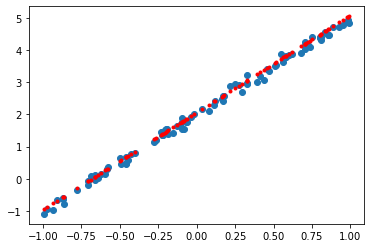

In [14]:
# function least square fit in pytorch

import torch
import numpy as np
import matplotlib.pyplot as plt

# create the data points
n=100
x = torch.ones(n,2)
x[:,0].uniform_(-1.,1.)
a = torch.Tensor([3.,2.])
y = x@a + 0.1 * torch.randn(n)
plt.scatter(x[:,0],y)
print(x.shape)
''''''
def mse(y_hat,y):
    return ((y_hat-y)**2).mean()

a = torch.tensor([3.1,2.5])
a = torch.nn.Parameter(a)
def update(lr):
    y_hat = x@a
    loss = mse(y,y_hat)
    #if t % 10 == 0: print(loss,a)
    loss.backward() # compte the gradient
    with torch.no_grad():
        a.sub_(lr*a.grad) # evolve a-=lr*grad
        a.grad.zero_() # set the gradient to 0
    
lr = 0.01
for t in range(100):
    update(lr)
print(a)
plt.plot(x[:,0],x@a.detach().numpy(),'r.')

torch.Size([100])
Parameter containing:
tensor([2.9994, 1.9893], requires_grad=True)


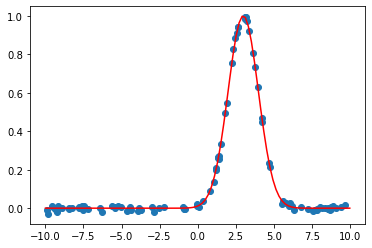

In [48]:
# 1D gaussian fitting using pytorch and gradient descent    

import torch
import numpy as np
import matplotlib.pyplot as plt
gauss = lambda x,p : torch.exp(-torch.square(x-p[0]) / p[1])

# create the data points
n = 100
x = torch.ones(n)
x[:].uniform_(-10.,10.)
a = torch.Tensor([3.,2.])
y = gauss(x,a) + 0.01 * torch.randn(n)
plt.scatter(x,y)
print(x.shape)

# define the loss function
def mse(y_hat,y):
    return ((y_hat-y)**2).mean()



def update(lr,lossfun,fun,x,a):
    y_hat = fun(x,a)
    loss = lossfun(y,y_hat)
    loss.backward() # compte the gradient
    with torch.no_grad():
        a.sub_(lr*a.grad) # evolve a-=lr*grad
        a.grad.zero_() # set the gradient to 0
    return a, loss

a = torch.tensor([3.1,3])
a = torch.nn.Parameter(a)  
lr = 1
for t in range(1000):
    a, loss = update(lr,mse,gauss,x,a)
print(a)
x0 = torch.linspace(-10,10,100)
plt.plot(x0,gauss(x0,a).detach().numpy(),'r-')


Elapsed time 0.8315224647521973, loss 0.00010011188714997843
Elapsed time 0.006995677947998047, loss 0.00010011189442593604
Elapsed time 0.00500035285949707, loss 0.00010011188714997843


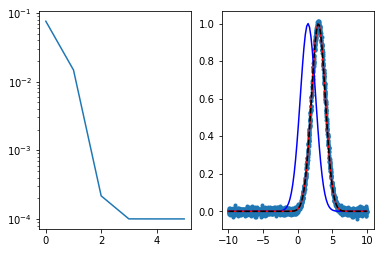

In [62]:
from scipy.optimize import curve_fit
import time

# levenberg marquardt in pytorch
def curve_fit_levenberg_marquardt_torch(model, xdata, ydata, init, niter=500, autograd=False):
    '''
    Levenberg marquardt using pytorch's autodiff capabilities
    Parameters
    ----------
    model : function to fit lambda x,beta: ...
    xdata : torch.Tensor with x data points
    ydata : torch.Tensor with y data points
    init : torch.Tensor with starting point
    niter : number of iterations
    autograd: enable automatic differentiation
    Result
    ------
    beta : estimated parameters
    cov : covariance matrix
    loss : list of mean square error 
    '''
    n = init.numel()
    m = xdata.numel()
    beta = init.clone()
    beta.resize_(n)
    loss = []
    l = 0.001
    p = 1e-3
    for k in range(niter):
        yhat = model(xdata, beta)
        residuals = yhat - ydata
        loss.append(torch.mean(torch.square(residuals)))
        if autograd:
            J = torch.autograd.functional.jacobian(model,(x,beta),vectorize=True)[1]     
        else:
            J = torch.zeros(m, n, device=xdata.device)
            for i in range(n):
                h = torch.zeros(n, device=xdata.device)
                h[i] += p
                J[:,i] = (model(xdata, beta + h) - yhat) / p
        JtJ = J.t() @ J
        A = JtJ + l * torch.diag(JtJ)
        delta = torch.linalg.solve(A , J.t() @ residuals)
        beta.sub_(delta)
        if k > 1:
            if loss[k] < loss[k-1]:
                l /= 5
            else:
                l *= 2
                beta.add_(delta)
            if torch.abs(loss[k]-loss[k-1]) / loss[k] < 1e-2 :
                break

    residuals = model(xdata, beta) - ydata 
    loss.append(torch.mean(torch.square(residuals)))     
    cov = A.inverse() * loss[-1]
    return beta, cov, loss

gauss = lambda x,p : torch.exp(-torch.square(x-p[0]) / p[1])

n = 2000
x = torch.ones(n)
x.uniform_(-10.,10.)
a = torch.Tensor([3.,2.])
y = gauss(x,a) + 0.01 * torch.randn(n)
init = torch.Tensor([1.5,2.5])

# pytorch version
start = time.time()
ahat,cov,loss = curve_fit_levenberg_marquardt_torch(gauss,x,y,init,30,True)
print(f'Elapsed time {time.time()-start}, loss {loss[-1]}')

start = time.time()
ahat1,cov1,loss1 = curve_fit_levenberg_marquardt_torch(gauss,x,y,init,30,False)
print(f'Elapsed time {time.time()-start}, loss {loss1[-1]}')

# scipy version
def gauss2(x,p0,p1):
    return np.exp(-np.square(x-p0) / p1)

start = time.time()
ahat2,cov2 = curve_fit(gauss2, x.numpy(), y.numpy(), init.numpy())
loss2 = np.mean(np.square(gauss2(x.numpy(), ahat2[0], ahat2[1]) - y.numpy()))
print(f'Elapsed time {time.time()-start}, loss {loss2}')

fig,ax = plt.subplots(1,2)
ax[0].semilogy(loss)
ax[1].plot(x,y,'.')
ax[1].plot(torch.linspace(-10,10,100),gauss(torch.linspace(-10,10,100),init),'b')
ax[1].plot(torch.linspace(-10,10,100),gauss(torch.linspace(-10,10,100),ahat),'r')
ax[1].plot(torch.linspace(-10,10,100),gauss(torch.linspace(-10,10,100),ahat2),'k--')



In [315]:
def f(*args):
    ret = []
    for x in args:
        ret.append(2*x+1)
    return tuple(ret)

x = torch.linspace(0,10,11)
torch.autograd.functional.jacobian(f,torch.split(x,1))

def f(x,a):
    return a[0] * x + a[1] + a[2]*x*x

x = torch.linspace(0,10,11)
a = torch.ones(3)
J = torch.autograd.functional.jacobian(f,(x,a))[1]
print(a.shape)
J



torch.Size([3])


tensor([[  0.,   1.,   0.],
        [  1.,   1.,   1.],
        [  2.,   1.,   4.],
        [  3.,   1.,   9.],
        [  4.,   1.,  16.],
        [  5.,   1.,  25.],
        [  6.,   1.,  36.],
        [  7.,   1.,  49.],
        [  8.,   1.,  64.],
        [  9.,   1.,  81.],
        [ 10.,   1., 100.]])

In [64]:
def fit_levenberg_marquardt_torch(model, ydata, init, niter=500, autograd=False):
    '''
    Levenberg marquardt using pytorch's autodiff capabilities
    Parameters
    ----------
    model : function to fit lambda beta: ...
    ydata : torch.Tensor with y data points
    init : torch.Tensor with starting point
    niter : number of iterations
    autograd: enable automatic differentiation
    Result
    ------
    beta : estimated parameters
    cov : covariance matrix
    loss : list of mean square error 
    '''
    n = init.numel()
    m = xdata.numel()
    beta = init.clone()
    beta.resize_(n)
    loss = []
    l = 0.001
    p = 1e-3
    for k in range(niter):
        yhat = model(beta)
        residuals = yhat - ydata
        loss.append(torch.mean(torch.square(residuals)))
        if autograd:
            J = torch.autograd.functional.jacobian(model,a,vectorize=True)[1]     
        else:
            J = torch.zeros(m, n, device=ydata.device)
            for i in range(n):
                h = torch.zeros(n, device=ydata.device)
                h[i] += p
                J[:,i] = (model(xdata, beta + h) - yhat) / p
        JtJ = J.t() @ J
        A = JtJ + l * torch.diag(JtJ)
        delta = torch.linalg.solve(A , J.t() @ residuals)
        beta.sub_(delta)
        if k > 1:
            if loss[k] < loss[k-1]:
                l /= 5
            else:
                l *= 2
                beta.add_(delta)
            if torch.abs(loss[k]-loss[k-1]) / loss[k] < 1e-2 :
                break

    residuals = model(beta) - ydata 
    loss.append(torch.mean(torch.square(residuals)))     
    cov = A.inverse() * loss[-1]
    return beta, cov, loss


array([-5.68806135e-06,  6.28122193e-06,  6.93605733e-06,  1.00000016e-01,
        9.99997377e-01, -4.25584563e-06,  4.65819546e-06, -5.13949450e-07])

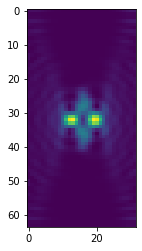

In [86]:
# Fitting a PSF aberrations

from scipy.optimize import least_squares

# We first generate some data
shape = [64,64,32] 
pixel_size = [100,100,300] 
wavelength = 500
NA = 1
medium_refractive_index = 1.3
aberrations = np.array([0,0,0,0.1,1])

otf,psf = generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index,aberrations)
plt.imshow(np.fft.fftshift(psf[:,0,:]))

x0 = np.array([0,0,0,0.1,0,1,0,0])
grid = generate_otf3d_grid(shape,pixel_size)
model = lambda c: (generate_otf3d(shape,pixel_size,wavelength,NA,medium_refractive_index,c)[1] - psf).ravel()
res = least_squares(model, x0)
res.x

In [649]:
x = np.array([-1,2,3,4])
#print(np.clip(x,0,None))
print(np.maximum(x,0))


[0 2 3 4]


In [10]:
import math
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

class PSFGenerator:
    '''
    Scalar point spread function generator

    This class enable to precompute some arrays in order to accelerate
    evaluation when fitting for example.
    
    '''
    def __init__(self, shape, pixel_size, wavelength, NA, medium_refractive_index,mode='wf'):
        self.shape = np.array(shape)
        self.pixel_size = pixel_size
        self.wavelength = wavelength
        self.NA = NA
        self.medium_refractive_index = medium_refractive_index
        self.aberration_names = ('[1] Tilt-X','[2] Tilt-Y','[3] Focus','[4] Astigmatism & Defocus','[5] Astigmatism & Defocus','[6] Coma & Tilt','[7] Coma & Tilt','[8] Spherical & Defocus','[9]','[10]','[11]','[12]','[13]','[14]','[15]')
        self.mode = mode
        f = [np.fft.fftfreq(n, pixel_size[k]) for k, n in enumerate(shape)]
        ez = np.concatenate((np.arange(0,shape[2]//2), np.arange((-shape[2])//2,0))) * pixel_size[2]
        [kx,ky,kz] = np.meshgrid(*f)
        z = np.meshgrid(f[0],f[1],ez)[2]
        d2 = np.square(kx) + np.square(ky)
        rho = np.sqrt(d2) * wavelength / NA
        # pupille with correction for high NA
        corr =  np.power(np.maximum( 1 - d2 / (medium_refractive_index / wavelength)**2, 1e-3), -0.25)
        self.P = np.where(rho <= 1.0, 1.0, 0.0) * corr
        # defocus term on a spherical cap
        self.defocus = z * np.sqrt(np.clip((medium_refractive_index / wavelength)**2 - d2, 0, None))
        self.dist = np.sqrt(d2 + np.square(kz))
        # 2D array stored to accelerate aberration computation
        [kx,ky] = np.meshgrid(f[0],f[1])
        rho = np.sqrt(np.square(kx) + np.square(ky)) * wavelength / NA
        theta = np.arctan2(ky, kx)
        self.r = rho
        self.r2 = np.square(rho)
        self.r3 = np.power(rho,4.0)
        self.r4 = np.power(rho,4.0)
        self.c = np.cos(theta)
        self.s = np.sin(theta)
        self.c2 = np.cos(2*theta)
        self.s2 = np.sin(2*theta)
        self.c3 = np.cos(3*theta)
        self.s3 = np.sin(3*theta)

    def fft_sphere(self, alpha, l, type):
        '''
        Fourier transform of uniform sphere or shell in 2D or 3D
        Parameters
        ----------
        alpha : frequency
        l : radius of the sphere
        type : type uniform3, shell3, uniform2, shell2
        Result
        ------
        fft of the sphere or shell
        Note
        ----
        Useful for computing image of beads, pinhole image, etc
        https://doi.org/10.1093/qmath/12.1.165
        '''
        x = 2 * math.pi * alpha * l
        if type == "uniform3":
            return 3 * (np.sin(x) / np.power(x,3.0) - np.cos(x) / np.power(x,2.0))
        elif type == "uniform2":
            return 2 * np.special.j1(x) / x
        elif type == "shell2": 
            return 2 * np.special.j1(x)
        elif type == "shell3":
            return np.sin(x) / x

    def generate_psf(self,aberrations=None,mode='widefield',pinhole=1.0):
        '''
        Generate the point spread function
        '''
        if aberrations is not None:
            phase = self.defocus + self.zernike_polynomial(aberrations)
            
        if mode == 'widefield':
            psf = np.square(np.abs(np.fft.fft2( self.P * np.exp(2j * math.pi * phase), axes=[0,1])))
            psf = psf / psf.sum()
        if mode == 'confocal':
            # assuming same detection and excitation psf
            psf = np.square(np.abs(np.fft.fft2( self.P * np.exp(2j * math.pi * phase), axes=[0,1])))
            D = self.fft_sphere(self.rho, pinhole, "uniform2")
            psf = psf * np.real(np.fft.ifftn(np.fft(np.fft.fftn(psf) * D)))
            psf = psf / psf.sum()
        elif mode == 'ism': 
            # assuming same detection and excitation psf
            psf = np.power(np.abs(np.fft.fft2( self.P * np.exp(2j * math.pi * phase), axes=[0,1])), 4)
            psf = np.power(psf, 2.0)
            psf = psf / psf.sum()
        return psf

    def generate_otf(self,aberrations=None, mode='widefield'):
        '''
        Generate the optical transfer function
        '''
        psf = self.generate_psf(aberrations, mode)
        otf = np.fft.fftn(psf)
        return otf

    def generate_bead(self, params, mode='widefield'):
        '''
        Generate the image of a bead
        params : [background, amplitude, sigma, 15 zernike coefficients ]
        '''
        otf = self.generate_otf(params[3:], mode)
        sigma = 1000*params[2]   
        if abs(sigma) > 1e-6 :
            obj = self.fft_sphere(self.dist, sigma, 'shell3d')            
            bead = np.fft.fftshift(np.real(np.fft.ifftn(otf * obj)))
        else:
            bead = np.fft.fftshift(np.real(np.fft.ifftn(otf)))

        bead = bead / np.max(bead)
        bead = params[0] + params[1]**2 * bead
        bead = np.clip(bead,0,2*params[1])
        return bead
        
    def zernike_polynomial(self,coefficients):
        '''
        Zernike polynomials
        Parameter
        ---------
        coefficient: 15 or less Zernike coefficients
        Note
        ----
        http://wyant.optics.arizona.edu/zernikes/Zernikes.pdf
        
        '''
        if coefficients.shape[0] < 15:
            coefficients = np.pad(coefficients,(0,15-coefficients.shape[0]))
        P = np.zeros(self.r.shape)
        P = P + coefficients[0] * self.r * self.c
        P = P + coefficients[1] * self.r * self.s
        P = P + coefficients[2] * (2. * self.r2 - 1.)
        P = P + coefficients[3] * self.r2 * self.c2
        P = P + coefficients[4] * self.r2 * self.s2
        P = P + coefficients[5] * (3. * self.r2 - 2.) * self.r * self.c
        P = P + coefficients[6] * (3. * self.r2 - 2.) * self.r * self.s
        P = P + coefficients[7] * (6. * self.r4 - 6. * self.r2 + 1.)
        P = P + coefficients[8] * self.r3 * self.c3
        P = P + coefficients[9] * self.r3 * self.s3
        P = P + coefficients[10] * (4. * self.r3 - 3) * self.r2 * self.c2
        P = P + coefficients[11] * (4. * self.r3 - 3) * self.r2 * self.s2
        P = P + coefficients[12] * (10. * self.r4 - 12. * self.r2 + 3.) * self.r  * self.c
        P = P + coefficients[13] * (10. * self.r4 - 12. * self.r2 + 3.) * self.r  * self.s
        P = P + coefficients[14] * ((20. * self.r4 - 30 * self.r2 + 12.)  * self.r2 - 1.0)
        P = np.where(self.r < 1.0, P, 0)
        return np.moveaxis(np.broadcast_to(P, self.shape[[2,0,1]]), 0, -1)
    
    def fit_bead(self,bead, x0=None):
        '''
        Fit a bead estimating the contrast, sigma and aberrations
        Parameters
        ---------
        bead : a np.array with a bead at the center
        '''
        a = np.max(bead)
        b = np.min(bead)
        bead = (bead - b) / (a - b)
        #model = lambda x: (self.generate_bead(x) - bead).ravel()
        model = lambda x: (np.sqrt(np.abs(self.generate_bead(x))) - np.sqrt(bead)).ravel()
        if x0 is None:
            x0 = np.array([0,1,0.1,0,0,0,0,0.1,0,0,0,0,0,0,0,0,0,0])
        res = least_squares(model, x0)
        background = res.x[0]
        amplitude = res.x[1]
        sigma = res.x[2]
        aberrations = res.x[3:]
        print(f'background:{background} amplitude:{amplitude} sigma:{sigma}')
        return sigma, aberrations, res.x
    
    
shape = [64,64,32]
pixel_size = [100,100,100]
wavelength = 500
NA = 1.4
medium_refractive_index = 1.4
psfgen = PSFGenerator(shape, pixel_size, wavelength, NA, medium_refractive_index)
xstar = np.concatenate(  (np.array([0,1,0.01]), 0.001 * np.random.randn(15))  )
bead = psfgen.generate_bead(xstar)
plt.imshow(np.log(1e-6+np.max(bead,axis=0)))
#sigma,aberrations,x = psfgen.fit_bead(bead)
#fig, ax = plt.subplots(1,2)
#ax[1].imshow(np.max(bead,axis=2))
#ax[0].barh(psfgen.aberration_names, aberrations)
#ax[0].invert_yaxis()
#ax[0].set_box_aspect(1)
#ax[0].set_title('Zernike coefficients')

UnboundLocalError: local variable 'sigma' referenced before assignment

background:0.011999138590034817 amplitude:1.0089450675059766 sigma:0.05386428261587414
background:0.011919524195973493 amplitude:0.9383227233268577 sigma:0.05307856984971326


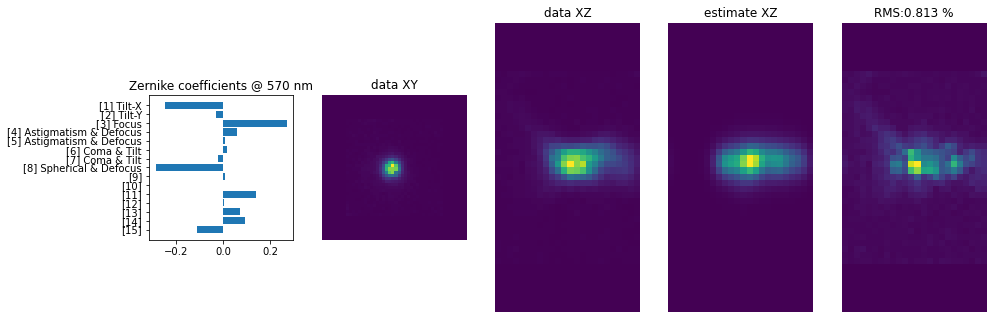

In [658]:
import tifffile
from skimage.transform import rescale

def analyze_bead(filename,channel):
    wavelength = [510,570,670]
    bead = tifffile.imread(filename)
    bead = np.moveaxis(bead[:,channel,:,:],0,-1)
    bead = bead[:,:,9:33]
    bead = rescale(bead, zoom)
    bead = np.pad(bead-np.median(bead),((8,8),(8,8),(0,0)))
    pixel_size = np.array([65.4762,65.4762,100])/zoom
    NA = 1.4
    medium_refractive_index = 1.335
    psfgen = PSFGenerator(bead.shape, pixel_size, wavelength[channel], NA, medium_refractive_index,'ism')
    x = np.array([0,1.0,0.1,0,0,0,0.1,0.1,0,0,-0.1])
    s,a,x = psfgen.fit_bead(bead, x)
    s,a,x = psfgen.fit_bead(bead, np.concatenate((x,0.01 * np.random.randn(18-x.shape[0]))))
    # make a figure
    fig, ax = plt.subplots(1, 5, figsize=(15,30))
    ax[0].barh(psfgen.aberration_names[:a.shape[0]], a)
    ax[0].invert_yaxis()
    ax[0].set_box_aspect(1)
    ax[0].set_title(f'Zernike coefficients @ {wavelength[channel]} nm')
    ax[1].imshow(np.max(bead, axis=2))
    ax[1].axis('off')
    ax[1].set_title('data XY')
    ax[2].imshow(np.max(bead, axis=0))
    ax[2].axis('off')
    ax[2].set_title('data XZ')
    ax[3].imshow(np.max(psfgen.generate_bead(x), axis=0))
    ax[3].axis('off')
    ax[3].set_title('estimate XZ')
    residuals = psfgen.generate_bead(x) - (bead - np.min(bead)) / (np.max(bead) - np.min(bead))
    ax[4].imshow(np.max(np.abs(residuals), axis=0))
    ax[4].axis('off')
    ax[4].set_title(f'RMS:{100*np.sqrt(np.mean(np.square(residuals))):.3f} %')


analyze_bead('C:\\Users\\jeromeb\\Documents\\work\\data\\buzz\\Beads_test_All_collors_Sulfochamber_RT_merged-crop.tif',1)

In [1]:
analyze_bead('C:\\Users\\jeromeb\\Documents\\work\\data\\buzz\\75degree2.tif',0)

NameError: name 'analyze_bead' is not defined

In [34]:
x = np.ones((1,5))
print(x)
print(x.shape)
y = np.tile(x,[4,1])
print(y)
for i in range(4):
    y[:,i] = y[:,i] + i
y

[[1. 1. 1. 1. 1.]]
(1, 5)
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]


array([[1., 2., 3., 4., 1.],
       [1., 2., 3., 4., 1.],
       [1., 2., 3., 4., 1.],
       [1., 2., 3., 4., 1.]])